In [2]:
import csv
import glob
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import shutil
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
%matplotlib inline

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['legend.fontsize'] = 16

In [3]:
raw_data = pd.read_csv('fighter_data.csv')

In [4]:
# df_5w = raw_data[((raw_data['w'].astype(int)+raw_data['l'].astype(float)+raw_data['d'].astype(float)) >= 10)
#                 & (raw_data['w'].astype(int) >= 5)]
df_5w = raw_data[((raw_data['w'].astype(int)+raw_data['l'].astype(float)+raw_data['d'].astype(float)) >= 5)]

In [5]:
significant_df = df_5w[(df_5w['SLpM']
           + df_5w['Str. Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['SApM']
           + df_5w['Str. Def'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Avg']
           + df_5w['TD Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Def.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['Sub. Avg.']) > 0
          ]
significant_df.head()

,first,last,nickname,height,weight,reach,stance,w,l,d,belt,SLpM,Str. Acc.,SApM,Str. Def,TD Avg,TD Acc.,TD Def.,Sub. Avg.
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,n/a,Orthodox,4,6,0,n/a,3.29,38%,4.41,57%,0.00,0%,77%,0.0
2,David,Abbott,Tank,"6' 0""",265 lbs.,n/a,Switch,10,14,0,n/a,1.35,30%,3.55,38%,1.07,33%,66%,0.0
3,Shamil,Abdurakhimov,Abrek,"6' 3""",235 lbs.,"76.0""",Orthodox,16,4,0,n/a,2.48,45%,2.50,58%,1.40,22%,77%,0.3
4,Hiroyuki,Abe,Abe Ani,"5' 6""",145 lbs.,n/a,Orthodox,8,14,3,n/a,1.71,36%,3.11,63%,0.00,0%,33%,0.0
5,Papy,Abedi,Makambo,"5' 11""",185 lbs.,"74.0""",Southpaw,9,3,0,n/a,2.80,55%,3.15,48%,3.47,57%,50%,1.3


In [6]:
def extract_stats_df(input_df):
    df = input_df.filter(['SLpM','Str. Acc.','SApM', 'Str. Def', 'TD Avg', 
                                     'TD Acc.', 'TD Def.', 'Sub. Avg.'], 
                                     axis=1)
    df['Str. Acc.'] = df['Str. Acc.'].apply(lambda x: x.strip('%')).astype(float)
    df['Str. Def'] = df['Str. Def'].apply(lambda x: x.strip('%')).astype(float)
    df['TD Acc.'] = df['TD Acc.'].apply(lambda x: x.strip('%')).astype(float)
    df['TD Def.'] = df['TD Def.'].apply(lambda x: x.strip('%')).astype(float)
    return df

In [7]:
stats_df = extract_stats_df(significant_df)

In [8]:
xticks = ['SLpM','Str. Acc.','SApM', 'Str. Def', 'TD Avg', 'TD Acc.', 'TD Def.', 'Sub. Avg.']

In [9]:
stats_df.as_matrix().shape

(2071, 8)

In [10]:
def correlation_matrix(df):
    a = df.astype(float).as_matrix().transpose()
    b = np.corrcoef(a)
    fig, ax = plt.subplots()
    # im = ax.imshow(np.square(stats_df.corr()),interpolation='nearest')
    im = ax.imshow(np.square(b),interpolation='nearest')
    fig.colorbar(im)
    ax.set_yticks(range(len(xticks)))
    ax.set_yticklabels(xticks, rotation='horizontal')
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xticks, rotation='vertical')
    ax.set_title('MMA_STATS_CORRELATION')

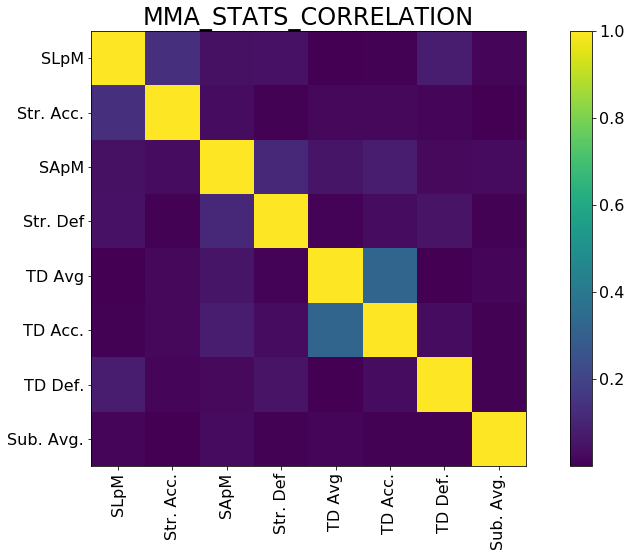

In [11]:
correlation_matrix(stats_df)

In [12]:
def do_kmeans_get_labels(df):
    est = KMeans(n_clusters=5, random_state=0).fit(df)
    labels = est.labels_
    return labels

In [13]:
labels = do_kmeans_get_labels(stats_df)
stats_df_labeled = stats_df.copy()
stats_df_labeled['Name'] = labels

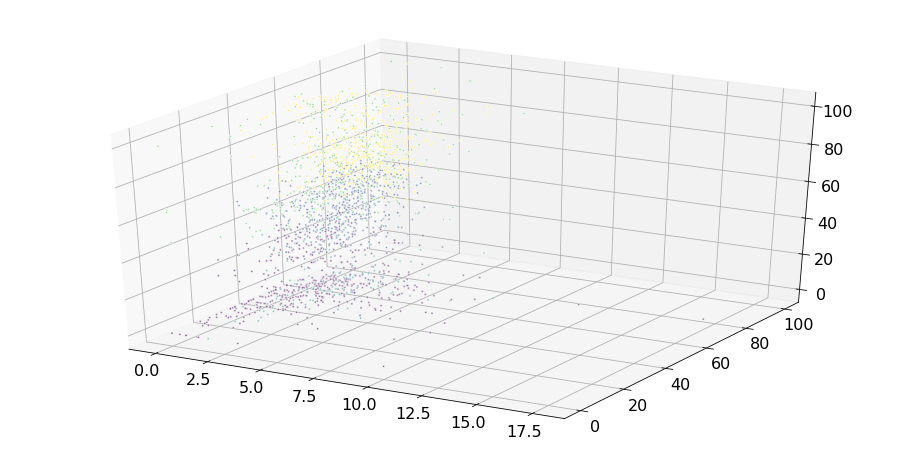

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(stats_df['SLpM'], stats_df['Str. Def'], 
           stats_df['TD Def.'], c=labels, marker='.', facecolors='none', edgecolors='white')

([], <a list of 0 Text yticklabel objects>)

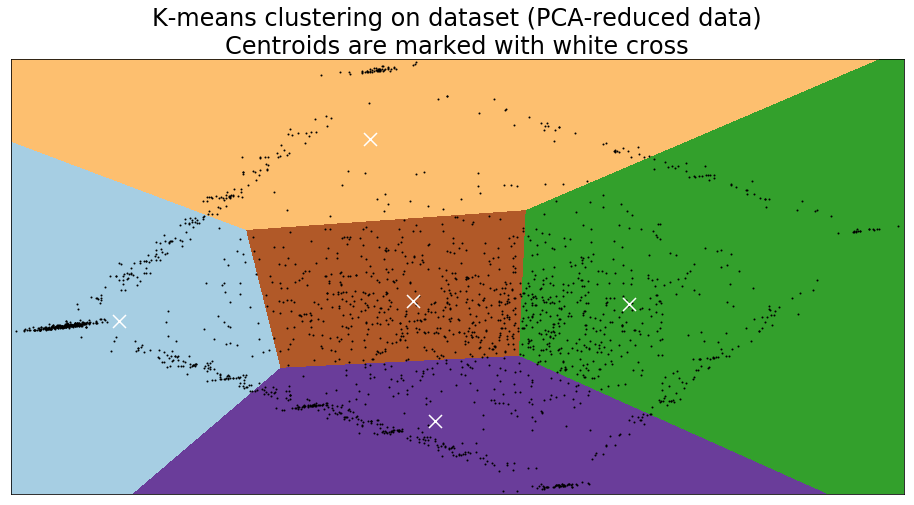

In [15]:
reduced_data = PCA(n_components=2).fit_transform(stats_df)
# kmeans = KMeans(init='k-means++', n_clusters=8, n_init=10)
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

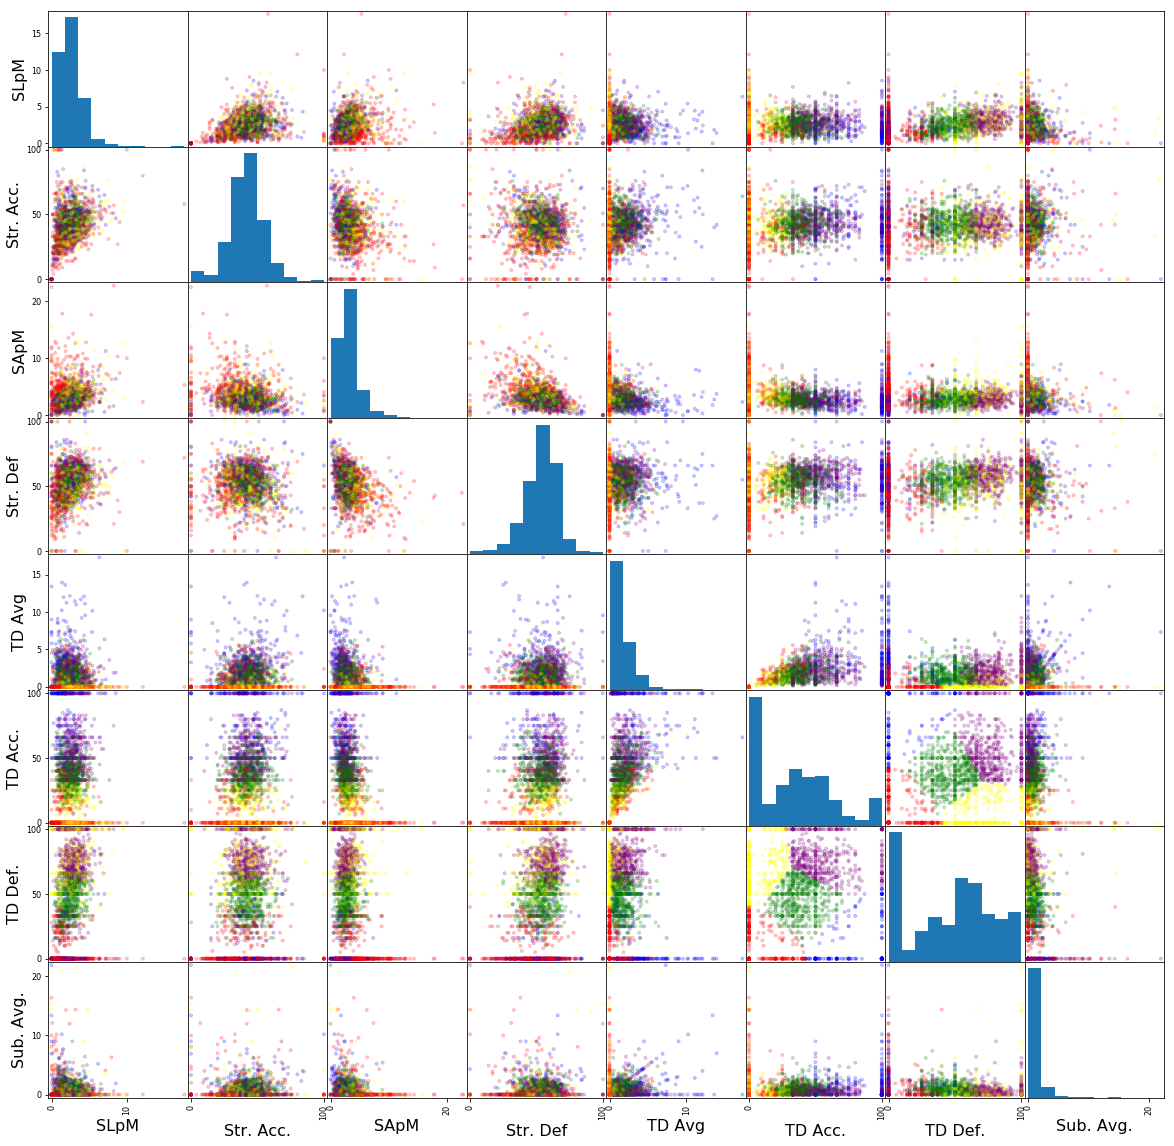

In [16]:
#more attempts to visualize the multi-dimensional data
import pandas
from pandas.tools.plotting import parallel_coordinates
from pandas.tools.plotting import scatter_matrix

color_wheel = {1: "red", 
               2: "green", 
               3: "blue",
               4: "yellow",
               5: "purple"}

vfunc = np.vectorize(lambda x: color_wheel.get(x + 1))
colors = vfunc(labels)

scatter_matrix(stats_df, c=colors, alpha=0.2, figsize=(20, 20), diagonal='hist')
# scatter_matrix(stats_df, alpha=0.2, figsize=(16, 16), diagonal='kde')
pass

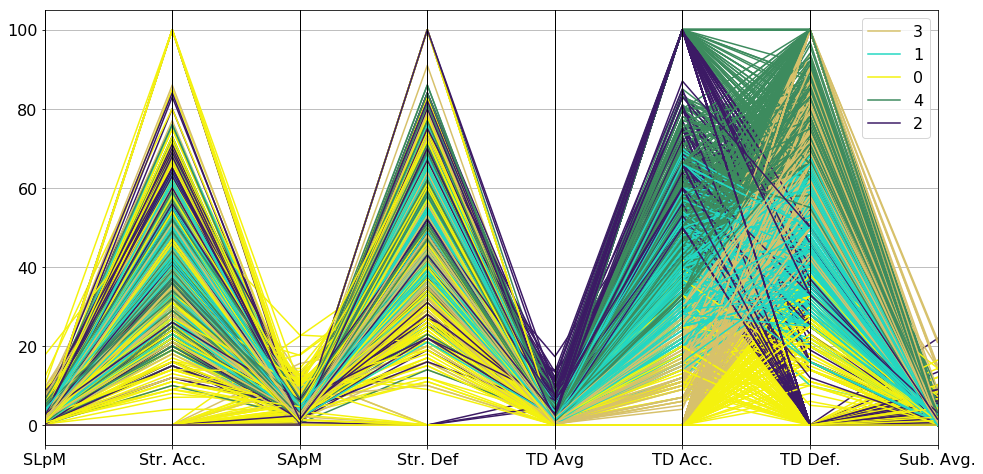

In [17]:
_ = parallel_coordinates(stats_df_labeled, 'Name')

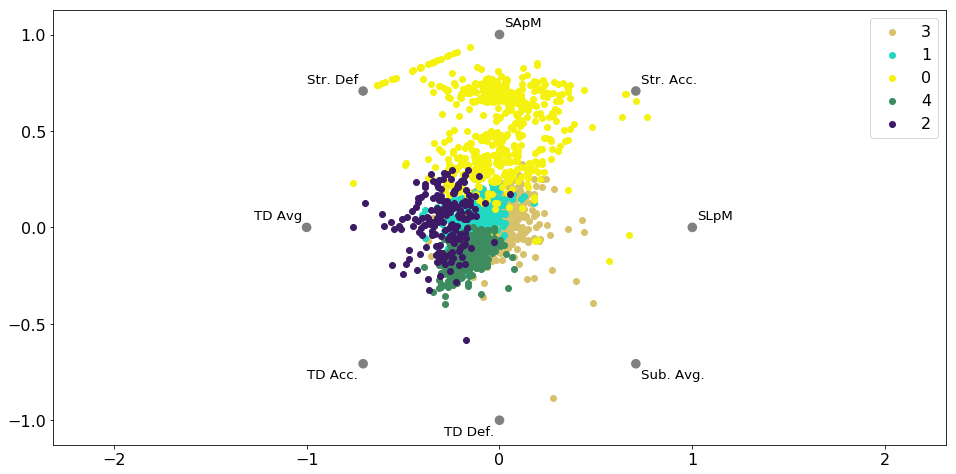

In [18]:
from pandas.tools.plotting import radviz
radviz(stats_df_labeled, 'Name')

In [19]:
#load the current top10 ranked fighters in all divisions
top10_all_class = np.genfromtxt('./top10.csv', delimiter=',', dtype='str')

significant_df = df_5w[(df_5w['SLpM']
           + df_5w['Str. Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['SApM']
           + df_5w['Str. Def'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Avg']
           + df_5w['TD Acc.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['TD Def.'].apply(lambda x: x.strip('%')).astype(float)
           + df_5w['Sub. Avg.']) > 0
          ]

top10_df = significant_df[(significant_df['first'] + ' ' + significant_df['last']).isin(top10_all_class)]
top10_df.head()

,first,last,nickname,height,weight,reach,stance,w,l,d,belt,SLpM,Str. Acc.,SApM,Str. Def,TD Avg,TD Acc.,TD Def.,Sub. Avg.
13,Jessica,Aguilar,Jag,"5' 3""",115 lbs.,"63.0""",Orthodox,19,5,0,n/a,4.67,37%,7.40,55%,0.00,0%,0%,0.0
32,Jose,Aldo,Junior,"5' 7""",145 lbs.,"70.0""",Orthodox,26,2,0,n/a,3.28,43%,2.09,71%,0.83,72%,92%,0.2
49,Thomas,Almeida,Thominhas,"5' 7""",135 lbs.,"70.0""",Southpaw,22,1,0,n/a,6.46,49%,4.47,66%,0.00,0%,80%,0.0
55,Eddie,Alvarez,The Underground King,"5' 9""",155 lbs.,"69.0""",Orthodox,28,5,0,n/a,3.43,42%,3.28,59%,3.58,38%,92%,0.5
72,Corey,Anderson,Overtime,"6' 3""",205 lbs.,"79.0""",n/a,10,2,0,n/a,5.11,46%,2.39,58%,4.44,52%,33%,0.0


In [20]:
top10_names_df = (top10_df['first'] + ' ' + top10_df['last']).as_matrix()
print [x for x in top10_all_class if x not in top10_names_df]

['Jessica Penne']


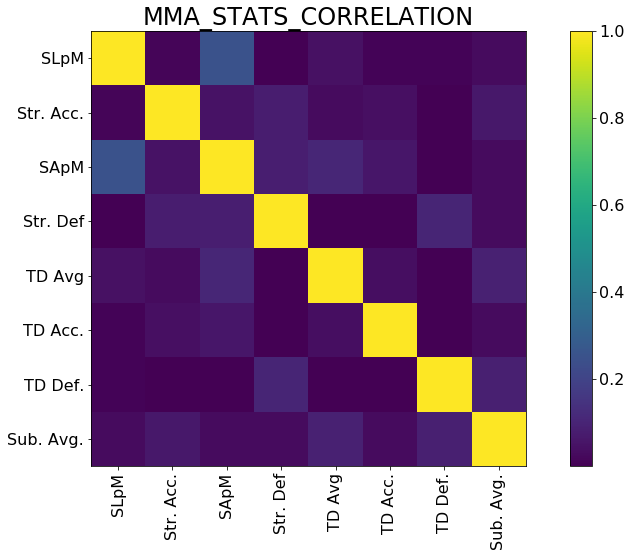

In [21]:
stats_top10_df = extract_stats_df(top10_df)
correlation_matrix(stats_top10_df)

In [22]:
top10_labels = do_kmeans_get_labels(stats_top10_df)
stats_top10_df_labeled = stats_top10_df.copy()
stats_top10_df_labeled['Name'] = top10_labels

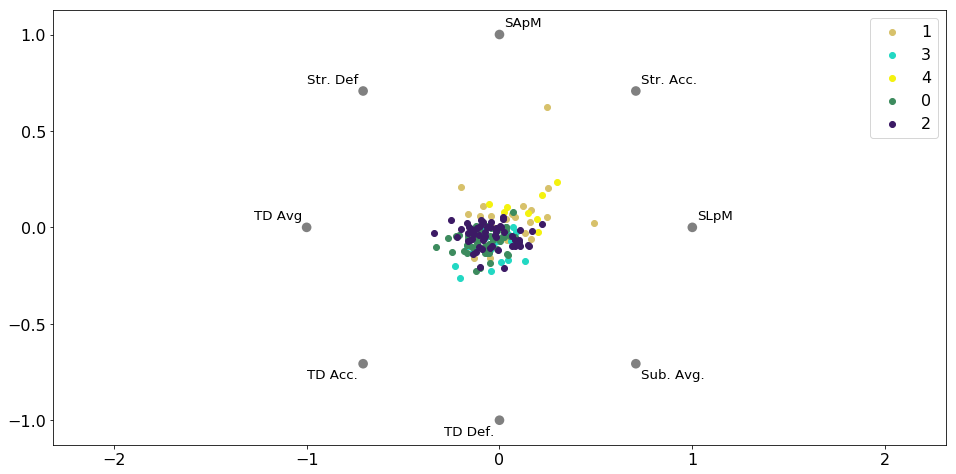

In [23]:
radviz(stats_top10_df_labeled, 'Name')

In [75]:
df_bisping = pd.read_csv('bisping_results.csv', delimiter=',', header=0)

In [77]:
#Create training dataset of fights won and the features associated with the winner
df_bisping[['first', 'last']] = df_bisping['name'].str.split(' ', expand=True)

In [93]:
#left outer join for intersection of the DF and bisping_res
opponent_stats = pd.merge(df_5w, df_bisping, on=['first', 'last'], how='inner')

In [95]:
# from IPython.display import display, HTML
# HTML(bisping_fight_stats.to_html())

In [97]:
bisping_stats = df_5w[(df_5w['first'] == 'Michael') & (df_5w['last'] == 'Bisping')]

In [98]:
deltas = opponent_stats - bisping_stats

In [104]:
bisping_stats['SLpM'].apply(np.sqrt)

pandas.core.series.Series

In [114]:
reach_op = lambda x: x.replace('"', '')
weight_op = lambda x: float(x.split()[0])

In [118]:
bisping_stats['reach'] = bisping_stats['reach'].apply(reach_op)
bisping_stats['weight'] = bisping_stats['weight'].apply(weight_op)

In [117]:
bisping_stats

,first,last,nickname,height,weight,reach,stance,w,l,d,belt,SLpM,Str. Acc.,SApM,Str. Def,TD Avg,TD Acc.,TD Def.,Sub. Avg.
203,Michael,Bisping,The Count,"6' 1""",185,75.0,Orthodox,31,7,0,n/a,4.44,38%,2.63,66%,1.1,43%,64%,0.3
